# BERT Fine-Tuning

Binary sentiment classification using `bert-base-uncased` fine-tuned with HuggingFace Trainer.

Prerequisite: run `00_preprocessing.ipynb` first.

In [1]:
!pip install -q transformers accelerate

zsh:1: /Users/pedrofonsecadeandrade/Dev/GitHub/phd-natural-processing-language/.venv/bin/pip: bad interpreter: /Users/pedrofonsecadeandrade/Dev/phd-nlp/.venv/bin/python: no such file or directory

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: /Library/Frameworks/Python.framework/Versions/3.13/bin/python3.13 -m pip install --upgrade pip


In [2]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

/Users/pedrofonsecadeandrade/Dev/GitHub/phd-natural-processing-language/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


## Load data and split

In [3]:
df = pd.read_csv('../data/reviews_extraidas.csv')
df['label'] = (df['Y'] > 5).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    df['X'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 435, Test: 109


## Prepare datasets

In [4]:
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.texts.iloc[idx]),
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels.iloc[idx], dtype=torch.long),
        }

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = ReviewDataset(X_train, y_train, tokenizer)
test_dataset = ReviewDataset(X_test, y_test, tokenizer)

print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

Train: 435, Test: 109


## Fine-tune BERT

In [5]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='weighted'),
    }

training_args = TrainingArguments(
    output_dir='/tmp/bert_checkpoints',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 2423.10it/s, Materializing param=bert.pooler.dense.weight]                               
BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those p

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.677236,0.784336,0.449541,0.407779
2,0.537342,0.458029,0.798165,0.801302
3,0.195502,0.482454,0.807339,0.807786


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]
/Users/pedrofonsecadeandrade/Dev/GitHub/phd-natural-processing-language/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]
/Users/pedrofonsecadeandrade/Dev/GitHub/phd-natural-processing-language/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]
There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.

TrainOutput(global_step=165, training_loss=0.5105926824338508, metrics={'train_runtime': 80.935, 'train_samples_per_second': 16.124, 'train_steps_per_second': 2.039, 'total_flos': 171679963622400.0, 'train_loss': 0.5105926824338508, 'epoch': 3.0})

## Evaluation

In [6]:
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(-1)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 (macro): {f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"F1 (weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")
print()
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

/Users/pedrofonsecadeandrade/Dev/GitHub/phd-natural-processing-language/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Accuracy: 0.7982
F1 (macro): 0.7953
F1 (weighted): 0.8013

              precision    recall  f1-score   support

    Negative       0.93      0.74      0.82        68
    Positive       0.67      0.90      0.77        41

    accuracy                           0.80       109
   macro avg       0.80      0.82      0.80       109
weighted avg       0.83      0.80      0.80       109



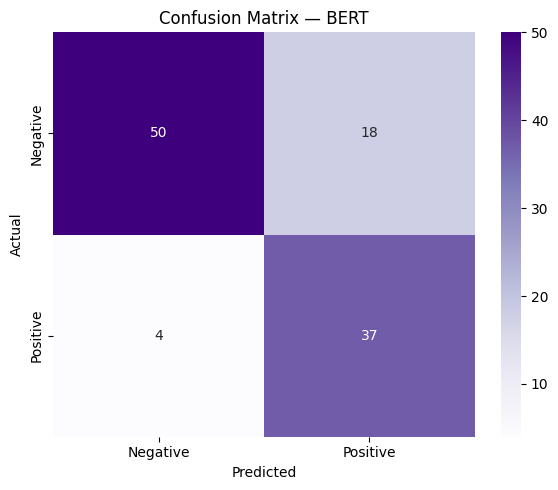

In [7]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix — BERT')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## Inference on new reviews

In [8]:
samples = [
    "This movie was absolutely amazing! I loved every moment of it.",
    "Terrible film. Waste of time and money. Do not watch.",
    "It was okay, nothing special but not bad either.",
]

label_map = {0: 'Negative', 1: 'Positive'}
model_cpu = model.cpu()
model_cpu.eval()

for text in samples:
    inputs = tokenizer(text, truncation=True, padding='max_length', max_length=256, return_tensors='pt')

    with torch.no_grad():
        logits = model_cpu(**inputs).logits
        probs = torch.softmax(logits, dim=1)[0]
        pred = logits.argmax(dim=1).item()

    print(f"{label_map[pred]:>8s} ({probs[pred]:.2%})  |  {text}")

Positive (81.25%)  |  This movie was absolutely amazing! I loved every moment of it.
Negative (86.82%)  |  Terrible film. Waste of time and money. Do not watch.
Positive (70.29%)  |  It was okay, nothing special but not bad either.
